### Basic OLS research

In [ ]:
import numpy as np 
import pandas as pd
import plotly.express as px
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab as pl
import plotly.figure_factory as ff
from IPython.display import display, HTML
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.stattools as sss

In [2]:
df = pd.read_csv('vopreco.csv', sep=';')
df = df.iloc[:,:7]

In [3]:
df.head()

,year,month,title_length,authors_no,pages_no,views,cited
0,2023,1,51,5,21,770,0
1,2023,1,69,1,19,357,0
2,2023,1,100,1,14,524,1
3,2023,1,73,2,27,555,2
4,2023,1,75,1,19,329,1


In [4]:
display(px.scatter(df, y = 'views', x = 'year'))
display(px.scatter(df, y = 'views', x = 'authors_no'))
display(px.scatter(df, y = 'views', x = 'title_length'))

In [5]:
df = df[df['views']<20000]

<Axes: >

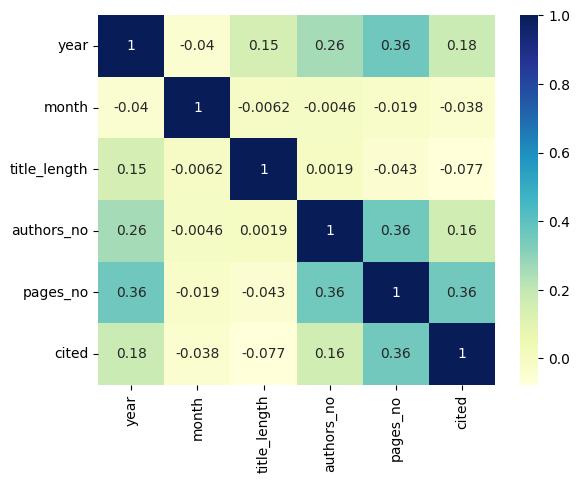

In [6]:
sb.heatmap(df.drop(columns=['views']).corr(numeric_only=True), cmap="YlGnBu", annot=True)

#### Видим, что по графикам явная зависимость не наблюдается. По матрице корреляций понимаем, что факторы убирать не надо (Маленькая корреляция)

### Закодируем Год + месяц числовым значением. Отдельно закодируем год (делать качественными не имеет смысла)

In [7]:
df['dt'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
df['dt_int'] = df['dt'].rank(method='dense')
df['year_int'] = df['year'].rank(method='dense')

In [8]:
df.sort_values('dt_int')

,year,month,title_length,authors_no,pages_no,views,cited,dt,dt_int,year_int
2334,2003,1,117,1,20,2639,9,2003-01-01,1.0,1.0
2335,2003,1,83,1,18,663,8,2003-01-01,1.0,1.0
2336,2003,1,33,1,17,676,0,2003-01-01,1.0,1.0
2337,2003,1,72,1,14,359,0,2003-01-01,1.0,1.0
2338,2003,1,31,1,23,415,1,2003-01-01,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
50,2023,7,100,1,15,192,0,2023-07-01,247.0,21.0
51,2023,7,70,2,31,173,0,2023-07-01,247.0,21.0
52,2023,7,78,6,19,209,0,2023-07-01,247.0,21.0
53,2023,7,62,1,15,173,0,2023-07-01,247.0,21.0


### Еще графики

In [9]:
px.histogram(df[(df.index>np.percentile(df.index, 20)) & (df.index<=np.percentile(df.index, 80))], x="views", nbins=1000)
# Видим несимметричный график, скорее всего ошибки тоже будут смещены  

#### Можно посмотреть по месяцам, из предположения, что студенты активно ищут статьи в определенные месяцы при заполнении списка литературы

In [10]:
px.line(df[['views','month']].sort_values('month').groupby('month').sum().reset_index(), x='month', y="views")

#### Добавлю месяц как качетвенную переменную, так как есть заметные скачки 

In [11]:
df = df.join( pd.get_dummies(df['month'],dtype=int, prefix='month_'))

In [12]:
df.head()

,year,month,title_length,authors_no,pages_no,views,cited,dt,dt_int,year_int,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
0,2023,1,51,5,21,770,0,2023-01-01,241.0,21.0,...,0,0,0,0,0,0,0,0,0,0
1,2023,1,69,1,19,357,0,2023-01-01,241.0,21.0,...,0,0,0,0,0,0,0,0,0,0
2,2023,1,100,1,14,524,1,2023-01-01,241.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,2023,1,73,2,27,555,2,2023-01-01,241.0,21.0,...,0,0,0,0,0,0,0,0,0,0
4,2023,1,75,1,19,329,1,2023-01-01,241.0,21.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X = df[['year_int', 'title_length', 'authors_no', 'pages_no']].copy()
X = sm.add_constant(X)
m01 = sm.OLS(df['views'],X).fit(method='qr')
m01.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     97.49
Date:                Sat, 14 Sep 2024   Prob (F-statistic):           3.93e-77
Time:                        19:56:53   Log-Likelihood:                -19083.
No. Observations:                2479   AIC:                         3.818e+04
Df Residuals:                    2474   BIC:                         3.820e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          218.6481     38.314      5.707      0.000     143.517     293.779
year_int        24.0156      2.010     11.947      0.000      20.074      27.957
title_length    -0.3204      0.365     -0.877      0.380      -1.036       0.396
authors_no      25.4561     11.802      2.157      0.031       2.314      48.598
pages_no        14.5959      1.732      8.428      0.000      11.200      17.992
==============================================================================
Omnibus:                     2917.100   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           429347.973
Skew:                           5.998   Prob(JB):                         0.00
Kurtosis:                      66.346   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
px.histogram(m01.resid, nbins = 100)

##### на вид не очень нормально

#### можно поверх наложить график норм распределения

In [15]:
ff.create_distplot([m01.resid,np.random.normal(0,m01.resid.std(),2481)], ['resid','norm'], show_hist=False)

In [16]:
# Ненормальные ошибки (статистика далека от 1)
stats.shapiro(m01.resid)

ShapiroResult(statistic=np.float64(0.5962132853331559), pvalue=np.float64(3.5356298184436836e-60))

### Логарифм

In [17]:
X = df[['year_int', 'title_length', 'authors_no', 'pages_no']].copy()
X = sm.add_constant(X)
m02 = smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no+ title_length', data=df).fit()
m02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     182.4
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          3.89e-137
Time:                        19:56:56   Log-Likelihood:                -1628.2
No. Observations:                2479   AIC:                             3266.
Df Residuals:                    2474   BIC:                             3295.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        5.7914      0.034    172.682      0.000       5.726       5.857
authors_no       0.0348      0.010      3.373      0.001       0.015       0.055
year_int         0.0245      0.002     13.901      0.000       0.021       0.028
pages_no         0.0209      0.002     13.781      0.000       0.018       0.024
title_length    -0.0005      0.000     -1.475      0.140      -0.001       0.000
==============================================================================
Omnibus:                      336.386   Durbin-Watson:                   1.295
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1169.201
Skew:                           0.659   Prob(JB):                    1.29e-254
Kurtosis:                       6.095   Cond. No.                         286.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
px.histogram(m02.resid)

In [19]:
ff.create_distplot([m02.resid,np.random.normal(0,m02.resid.std(),2481)], ['resid','norm'], show_hist=False)

In [20]:
# сильно лучше, но не норм
stats.shapiro(m02.resid)

ShapiroResult(statistic=np.float64(0.9474116380839518), pvalue=np.float64(6.634608844667846e-29))

## Ищем спецификацию 

In [21]:
X = df[['year_int', 'title_length', 'authors_no', 'pages_no','cited'] + [col for col in df.columns if 'month_' in col]].copy()
X = sm.add_constant(X)
m03 = smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no+ title_length + C(month)', data=df).fit()
m03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     50.58
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          1.37e-131
Time:                        19:57:02   Log-Likelihood:                -1615.7
No. Observations:                2479   AIC:                             3263.
Df Residuals:                    2463   BIC:                             3357.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.9035      0.045    130.400      0.000       5.815       5.992
C(month)[T.2]     -0.1575      0.046     -3.449      0.001      -0.247      -0.068
C(month)[T.3]     -0.0935      0.045     -2.058      0.040      -0.183      -0.004
C(month)[T.4]     -0.1448      0.046     -3.167      0.002      -0.234      -0.055
C(month)[T.5]     -0.1380      0.045     -3.077      0.002      -0.226      -0.050
C(month)[T.6]     -0.1593      0.045     -3.507      0.000      -0.248      -0.070
C(month)[T.7]     -0.1758      0.045     -3.898      0.000      -0.264      -0.087
C(month)[T.8]     -0.0953      0.045     -2.105      0.035      -0.184      -0.007
C(month)[T.9]     -0.1160      0.046     -2.537      0.011      -0.206      -0.026
C(month)[T.10]    -0.1197      0.046     -2.603      0.009      -0.210      -0.030
C(month)[T.11]    -0.1104      0.046     -2.407      0.016      -0.200      -0.020
C(month)[T.12]    -0.0631      0.046     -1.368      0.171      -0.154       0.027
authors_no         0.0363      0.010      3.508      0.000       0.016       0.057
year_int           0.0244      0.002     13.909      0.000       0.021       0.028
pages_no           0.0209      0.002     13.800      0.000       0.018       0.024
title_length      -0.0005      0.000     -1.466      0.143      -0.001       0.000
==============================================================================
Omnibus:                      336.544   Durbin-Watson:                   1.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1137.029
Skew:                           0.668   Prob(JB):                    1.25e-247
Kurtosis:                       6.037   Cond. No.                         983.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
X = df.copy()
X = sm.add_constant(X)
m04= smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no + C(month)', data=X).fit()
m04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     54.01
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          5.27e-132
Time:                        19:57:02   Log-Likelihood:                -1616.8
No. Observations:                2479   AIC:                             3264.
Df Residuals:                    2464   BIC:                             3351.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.8709      0.039    148.743      0.000       5.794       5.948
C(month)[T.2]     -0.1578      0.046     -3.456      0.001      -0.247      -0.068
C(month)[T.3]     -0.0938      0.045     -2.065      0.039      -0.183      -0.005
C(month)[T.4]     -0.1448      0.046     -3.167      0.002      -0.234      -0.055
C(month)[T.5]     -0.1378      0.045     -3.073      0.002      -0.226      -0.050
C(month)[T.6]     -0.1609      0.045     -3.542      0.000      -0.250      -0.072
C(month)[T.7]     -0.1757      0.045     -3.894      0.000      -0.264      -0.087
C(month)[T.8]     -0.0963      0.045     -2.126      0.034      -0.185      -0.007
C(month)[T.9]     -0.1157      0.046     -2.530      0.011      -0.205      -0.026
C(month)[T.10]    -0.1188      0.046     -2.582      0.010      -0.209      -0.029
C(month)[T.11]    -0.1109      0.046     -2.420      0.016      -0.201      -0.021
C(month)[T.12]    -0.0636      0.046     -1.379      0.168      -0.154       0.027
authors_no         0.0364      0.010      3.519      0.000       0.016       0.057
year_int           0.0240      0.002     13.862      0.000       0.021       0.027
pages_no           0.0211      0.002     14.007      0.000       0.018       0.024
==============================================================================
Omnibus:                      336.286   Durbin-Watson:                   1.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1125.782
Skew:                           0.670   Prob(JB):                    3.46e-245
Kurtosis:                       6.017   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
X = df.copy()
X = sm.add_constant(X)
m05= smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no+ np.log(title_length) + C(month)', data=X).fit()
m05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     50.48
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          2.34e-131
Time:                        19:57:03   Log-Likelihood:                -1616.3
No. Observations:                2479   AIC:                             3265.
Df Residuals:                    2463   BIC:                             3358.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.9698      0.104     57.520      0.000       5.766       6.173
C(month)[T.2]           -0.1577      0.046     -3.453      0.001      -0.247      -0.068
C(month)[T.3]           -0.0936      0.045     -2.061      0.039      -0.183      -0.005
C(month)[T.4]           -0.1448      0.046     -3.167      0.002      -0.234      -0.055
C(month)[T.5]           -0.1377      0.045     -3.070      0.002      -0.226      -0.050
C(month)[T.6]           -0.1598      0.045     -3.516      0.000      -0.249      -0.071
C(month)[T.7]           -0.1759      0.045     -3.899      0.000      -0.264      -0.087
C(month)[T.8]           -0.0962      0.045     -2.124      0.034      -0.185      -0.007
C(month)[T.9]           -0.1158      0.046     -2.533      0.011      -0.205      -0.026
C(month)[T.10]          -0.1199      0.046     -2.605      0.009      -0.210      -0.030
C(month)[T.11]          -0.1109      0.046     -2.419      0.016      -0.201      -0.021
C(month)[T.12]          -0.0635      0.046     -1.377      0.169      -0.154       0.027
authors_no               0.0364      0.010      3.521      0.000       0.016       0.057
year_int                 0.0243      0.002     13.837      0.000       0.021       0.028
pages_no                 0.0210      0.002     13.909      0.000       0.018       0.024
np.log(title_length)    -0.0239      0.023     -1.030      0.303      -0.069       0.022
==============================================================================
Omnibus:                      336.789   Durbin-Watson:                   1.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1133.124
Skew:                           0.670   Prob(JB):                    8.82e-247
Kurtosis:                       6.029   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
X = df.copy()
X = sm.add_constant(X)
m06= smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no+ title_length + np.square(title_length) + C(month)', data=X).fit()
m06.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     47.41
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          9.42e-131
Time:                        19:57:03   Log-Likelihood:                -1615.7
No. Observations:                2479   AIC:                             3265.
Df Residuals:                    2462   BIC:                             3364.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.8926      0.056    105.481      0.000       5.783       6.002
C(month)[T.2]              -0.1572      0.046     -3.443      0.001      -0.247      -0.068
C(month)[T.3]              -0.0934      0.045     -2.057      0.040      -0.182      -0.004
C(month)[T.4]              -0.1448      0.046     -3.166      0.002      -0.234      -0.055
C(month)[T.5]              -0.1381      0.045     -3.079      0.002      -0.226      -0.050
C(month)[T.6]              -0.1593      0.045     -3.507      0.000      -0.248      -0.070
C(month)[T.7]              -0.1756      0.045     -3.894      0.000      -0.264      -0.087
C(month)[T.8]              -0.0949      0.045     -2.094      0.036      -0.184      -0.006
C(month)[T.9]              -0.1160      0.046     -2.536      0.011      -0.206      -0.026
C(month)[T.10]             -0.1191      0.046     -2.587      0.010      -0.209      -0.029
C(month)[T.11]             -0.1098      0.046     -2.393      0.017      -0.200      -0.020
C(month)[T.12]             -0.0625      0.046     -1.355      0.176      -0.153       0.028
authors_no                  0.0362      0.010      3.495      0.000       0.016       0.056
year_int                    0.0244      0.002     13.901      0.000       0.021       0.028
pages_no                    0.0209      0.002     13.752      0.000       0.018       0.024
title_length               -0.0002      0.001     -0.196      0.845      -0.002       0.002
np.square(title_length) -1.534e-06   4.63e-06     -0.331      0.740   -1.06e-05    7.55e-06
==============================================================================
Omnibus:                      336.066   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1135.643
Skew:                           0.667   Prob(JB):                    2.50e-247
Kurtosis:                       6.036   Cond. No.                     1.05e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
X = df.copy()
X = sm.add_constant(X)
m07= smf.ols(formula='np.log(views)~ authors_no+ year_int + pages_no + np.square(pages_no)+ C(month)', data=X).fit()
m07.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     51.80
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          1.43e-134
Time:                        19:57:04   Log-Likelihood:                -1608.7
No. Observations:                2479   AIC:                             3249.
Df Residuals:                    2463   BIC:                             3342.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7590      0.048    119.481      0.000       5.664       5.853
C(month)[T.2]          -0.1565      0.046     -3.439      0.001      -0.246      -0.067
C(month)[T.3]          -0.0963      0.045     -2.125      0.034      -0.185      -0.007
C(month)[T.4]          -0.1453      0.046     -3.188      0.001      -0.235      -0.056
C(month)[T.5]          -0.1373      0.045     -3.072      0.002      -0.225      -0.050
C(month)[T.6]          -0.1586      0.045     -3.502      0.000      -0.247      -0.070
C(month)[T.7]          -0.1739      0.045     -3.866      0.000      -0.262      -0.086
C(month)[T.8]          -0.0900      0.045     -1.993      0.046      -0.179      -0.001
C(month)[T.9]          -0.1149      0.046     -2.521      0.012      -0.204      -0.026
C(month)[T.10]         -0.1203      0.046     -2.623      0.009      -0.210      -0.030
C(month)[T.11]         -0.1104      0.046     -2.414      0.016      -0.200      -0.021
C(month)[T.12]         -0.0678      0.046     -1.473      0.141      -0.158       0.022
authors_no              0.0327      0.010      3.160      0.002       0.012       0.053
year_int                0.0240      0.002     13.902      0.000       0.021       0.027
pages_no                0.0387      0.005      8.384      0.000       0.030       0.048
np.square(pages_no)    -0.0005      0.000     -4.022      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      340.240   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.214
Skew:                           0.678   Prob(JB):                    6.92e-248
Kurtosis:                       6.030   Cond. No.                     4.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
X = df.copy()
X = sm.add_constant(X)
m08= smf.ols(formula='np.log(views)~ authors_no +dt_int+ pages_no + np.square(pages_no)+ C(month)', data=X).fit()
m08.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     51.80
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          1.43e-134
Time:                        19:57:04   Log-Likelihood:                -1608.7
No. Observations:                2479   AIC:                             3249.
Df Residuals:                    2463   BIC:                             3342.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7810      0.048    120.568      0.000       5.687       5.875
C(month)[T.2]          -0.1585      0.046     -3.483      0.001      -0.248      -0.069
C(month)[T.3]          -0.1003      0.045     -2.214      0.027      -0.189      -0.011
C(month)[T.4]          -0.1513      0.046     -3.320      0.001      -0.241      -0.062
C(month)[T.5]          -0.1453      0.045     -3.250      0.001      -0.233      -0.058
C(month)[T.6]          -0.1686      0.045     -3.723      0.000      -0.257      -0.080
C(month)[T.7]          -0.1858      0.045     -4.132      0.000      -0.274      -0.098
C(month)[T.8]          -0.1040      0.045     -2.304      0.021      -0.193      -0.015
C(month)[T.9]          -0.1309      0.046     -2.873      0.004      -0.220      -0.042
C(month)[T.10]         -0.1383      0.046     -3.015      0.003      -0.228      -0.048
C(month)[T.11]         -0.1304      0.046     -2.853      0.004      -0.220      -0.041
C(month)[T.12]         -0.0897      0.046     -1.951      0.051      -0.180       0.000
authors_no              0.0327      0.010      3.160      0.002       0.012       0.053
dt_int                  0.0020      0.000     13.902      0.000       0.002       0.002
pages_no                0.0387      0.005      8.384      0.000       0.030       0.048
np.square(pages_no)    -0.0005      0.000     -4.022      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      340.240   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.214
Skew:                           0.678   Prob(JB):                    6.92e-248
Kurtosis:                       6.030   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
X = df.copy()
X['authors_mult'] = np.where(X['authors_no']<=1,0,1)
X = sm.add_constant(X)
m09= smf.ols(formula='np.log(views)~ dt_int+ pages_no + np.square(pages_no)+ C(month)+ C(authors_mult)', data=X).fit()
m09.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     45.52
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          4.41e-119
Time:                        19:57:05   Log-Likelihood:                -1613.2
No. Observations:                2479   AIC:                             3258.
Df Residuals:                    2463   BIC:                             3352.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.7926      0.050    115.089      0.000       5.694       5.891
C(month)[T.2]           -0.1587      0.047     -3.369      0.001      -0.251      -0.066
C(month)[T.3]           -0.1012      0.049     -2.055      0.040      -0.198      -0.005
C(month)[T.4]           -0.1531      0.051     -2.999      0.003      -0.253      -0.053
C(month)[T.5]           -0.1454      0.049     -2.946      0.003      -0.242      -0.049
C(month)[T.6]           -0.1625      0.050     -3.246      0.001      -0.261      -0.064
C(month)[T.7]           -0.1828      0.048     -3.770      0.000      -0.278      -0.088
C(month)[T.8]           -0.1013      0.046     -2.209      0.027      -0.191      -0.011
C(month)[T.9]           -0.1295      0.047     -2.778      0.005      -0.221      -0.038
C(month)[T.10]          -0.1370      0.046     -2.962      0.003      -0.228      -0.046
C(month)[T.11]          -0.1324      0.049     -2.723      0.006      -0.228      -0.037
C(month)[T.12]          -0.0914      0.046     -2.001      0.045      -0.181      -0.002
C(authors_mult)[T.1]     0.0206      0.021      0.964      0.335      -0.021       0.062
dt_int                   0.0020      0.000     12.002      0.000       0.002       0.002
pages_no                 0.0407      0.005      8.055      0.000       0.031       0.051
np.square(pages_no)     -0.0006      0.000     -3.484      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      333.648   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.179
Skew:                           0.663   Prob(JB):                    2.10e-244
Kurtosis:                       6.017   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
star = Stargazer([m03, m04,m05,m06,m07,m08,m09])

In [33]:
star.add_line('AIC', [m03.aic, m04.aic,m05.aic, m06.aic,m07.aic,m08.aic,m09.aic])

In [34]:
star.custom_columns(['Model 3', 'Model 4','Model 5','Model 6','Model 7','Model 8','Model 9'])
star.add_line('BIC', [m03.bic, m04.bic,m05.bic, m06.bic,m07.bic,m08.bic,m09.bic])
with open('saving.html', 'w+') as f:
    f.write(star.render_html())

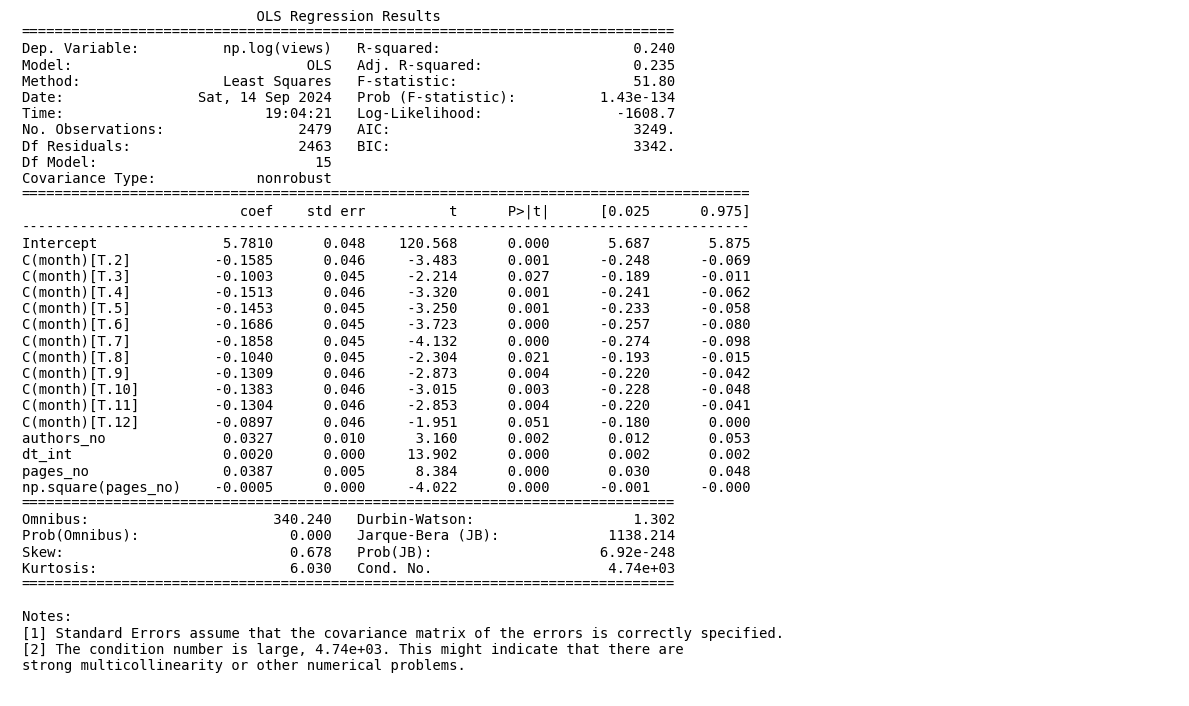

In [32]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, m08.summary(), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('iv_logit.png')

In [33]:
stats.shapiro(m08.resid)

ShapiroResult(statistic=np.float64(0.9491261423936088), pvalue=np.float64(1.7098293870383391e-28))

In [211]:
ff.create_distplot([m08.resid,np.random.normal(0,m08.resid.std(),10000)], ['resid','norm'], show_hist=False)

In [214]:
sms.het_breuschpagan(m08.resid, m08.model.exog)

(np.float64(166.09891500350204),
 np.float64(1.4810221100150784e-27),
 np.float64(11.791875588841412),
 np.float64(1.3628510613702387e-28))

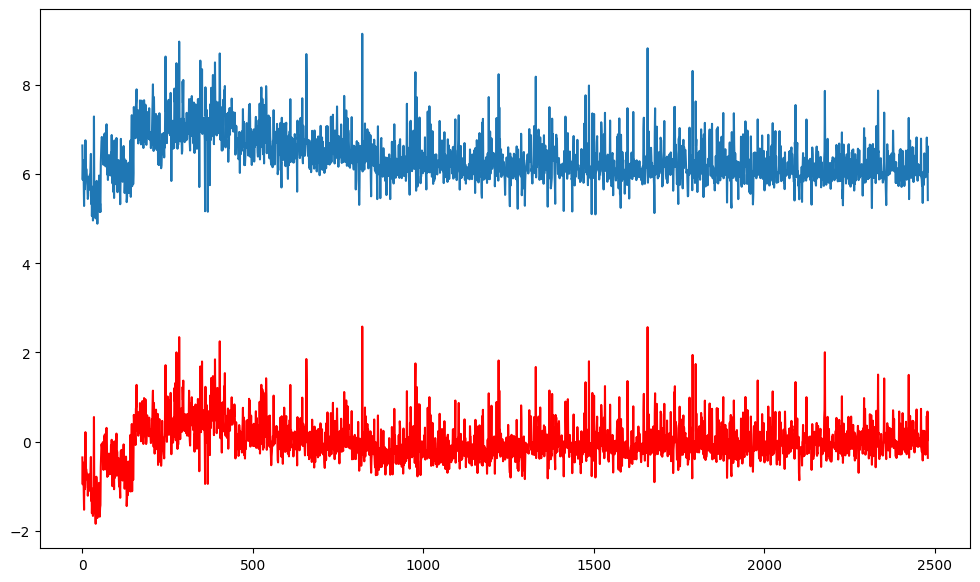

In [224]:
plt.plot(r.resid, color='red')
plt.plot(np.log(df['views']))

In [222]:
X = df.copy()
X = sm.add_constant(X)
m08= smf.ols(formula='np.log(views)~ authors_no +dt_int+ pages_no + np.square(pages_no)+ C(month)', data=X)
r = m08.fit(cov_type='HC3')
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     46.09
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          1.68e-120
Time:                        17:19:41   Log-Likelihood:                -1608.7
No. Observations:                2479   AIC:                             3249.
Df Residuals:                    2463   BIC:                             3342.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7810      0.050    115.440      0.000       5.683       5.879
C(month)[T.2]          -0.1585      0.047     -3.369      0.001      -0.251      -0.066
C(month)[T.3]          -0.1003      0.049     -2.041      0.041      -0.197      -0.004
C(month)[T.4]          -0.1513      0.051     -2.970      0.003      -0.251      -0.051
C(month)[T.5]          -0.1453      0.049     -2.948      0.003      -0.242      -0.049
C(month)[T.6]          -0.1686      0.050     -3.366      0.001      -0.267      -0.070
C(month)[T.7]          -0.1858      0.048     -3.842      0.000      -0.281      -0.091
C(month)[T.8]          -0.1040      0.046     -2.265      0.024      -0.194      -0.014
C(month)[T.9]          -0.1309      0.047     -2.805      0.005      -0.222      -0.039
C(month)[T.10]         -0.1383      0.046     -2.991      0.003      -0.229      -0.048
C(month)[T.11]         -0.1304      0.049     -2.675      0.007      -0.226      -0.035
C(month)[T.12]         -0.0897      0.046     -1.967      0.049      -0.179      -0.000
authors_no              0.0327      0.012      2.815      0.005       0.010       0.056
dt_int                  0.0020      0.000     11.790      0.000       0.002       0.002
pages_no                0.0387      0.005      7.697      0.000       0.029       0.049
np.square(pages_no)    -0.0005      0.000     -3.377      0.001      -0.001      -0.000
==============================================================================
Omnibus:                      340.240   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.214
Skew:                           0.678   Prob(JB):                    6.92e-248
Kurtosis:                       6.030   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
X = df.copy()
X = sm.add_constant(X)
r = smf.ols(formula='np.log(views)~ authors_no +dt_int+ pages_no + np.square(pages_no)+ C(month)', data=X)
r = r.fit(cov_type='HC3')
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(views)   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     46.09
Date:                Sat, 14 Sep 2024   Prob (F-statistic):          1.68e-120
Time:                        19:20:42   Log-Likelihood:                -1608.7
No. Observations:                2479   AIC:                             3249.
Df Residuals:                    2463   BIC:                             3342.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.7810      0.050    115.440      0.000       5.683       5.879
C(month)[T.2]          -0.1585      0.047     -3.369      0.001      -0.251      -0.066
C(month)[T.3]          -0.1003      0.049     -2.041      0.041      -0.197      -0.004
C(month)[T.4]          -0.1513      0.051     -2.970      0.003      -0.251      -0.051
C(month)[T.5]          -0.1453      0.049     -2.948      0.003      -0.242      -0.049
C(month)[T.6]          -0.1686      0.050     -3.366      0.001      -0.267      -0.070
C(month)[T.7]          -0.1858      0.048     -3.842      0.000      -0.281      -0.091
C(month)[T.8]          -0.1040      0.046     -2.265      0.024      -0.194      -0.014
C(month)[T.9]          -0.1309      0.047     -2.805      0.005      -0.222      -0.039
C(month)[T.10]         -0.1383      0.046     -2.991      0.003      -0.229      -0.048
C(month)[T.11]         -0.1304      0.049     -2.675      0.007      -0.226      -0.035
C(month)[T.12]         -0.0897      0.046     -1.967      0.049      -0.179      -0.000
authors_no              0.0327      0.012      2.815      0.005       0.010       0.056
dt_int                  0.0020      0.000     11.790      0.000       0.002       0.002
pages_no                0.0387      0.005      7.697      0.000       0.029       0.049
np.square(pages_no)    -0.0005      0.000     -3.377      0.001      -0.001      -0.000
==============================================================================
Omnibus:                      340.240   Durbin-Watson:                   1.302
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1138.214
Skew:                           0.678   Prob(JB):                    6.92e-248
Kurtosis:                       6.030   Cond. No.                     4.74e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 4.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

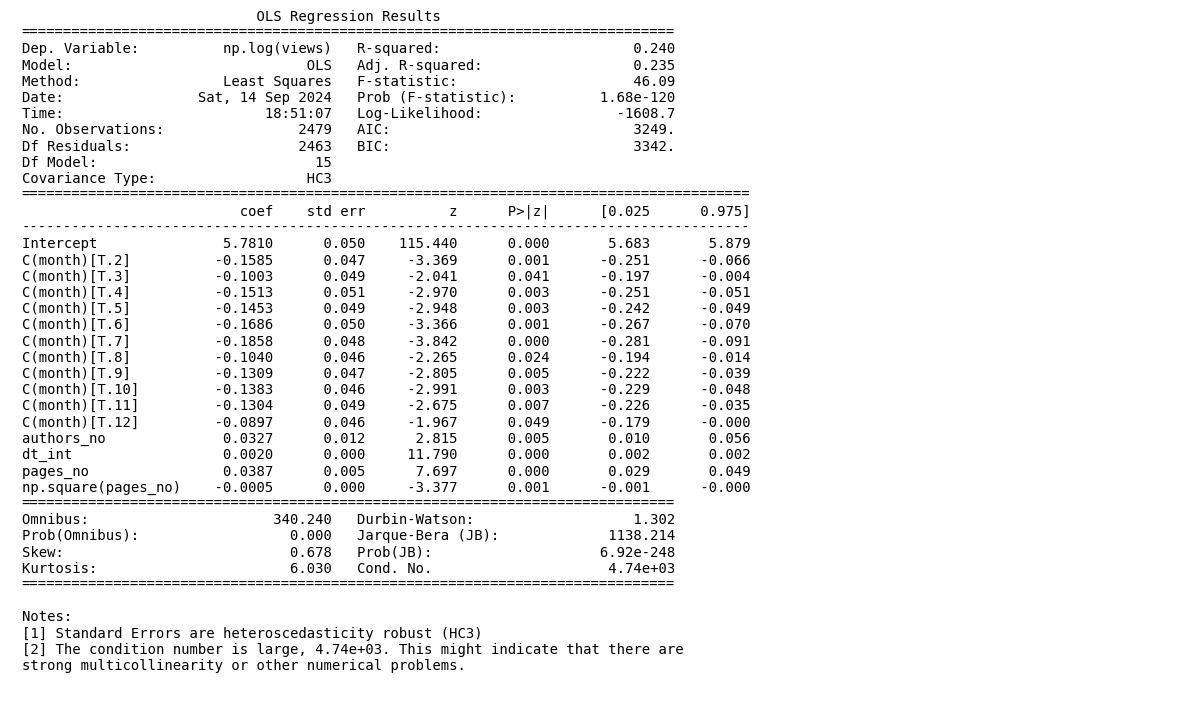

In [225]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, r.summary(), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('robust.png')

In [46]:
dg.acorr_breusch_godfrey(m01, nlags=1)

(np.float64(120.38385799766303),
 np.float64(5.213120343783196e-28),
 126.22201447984739,
 1.3382904676164276e-28)

In [42]:
sss.durbin_watson(r.resid)

np.float64(1.3023798465087406)

In [ ]:
.